# Predictor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [1]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, CenteredNorm, SymLogNorm
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, ttest_ind
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from shapely.geometry import Point

from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prsdk.persistence.serializers.sklearn_serializer import SKLearnSerializer
from prsdk.predictors.predictor import Predictor
from prsdk.predictors.neural_network.neural_net_predictor import NeuralNetPredictor
from prsdk.predictors.sklearn_predictors.linear_regression_predictor import LinearRegressionPredictor
from prsdk.predictors.sklearn_predictors.random_forest_predictor import RandomForestPredictor

from data.eluc_data import ELUCData
from data import constants

### Load Dataset

In [2]:
dataset = ELUCData.from_hf()

Using the latest cached version of the dataset since projectresilience/ELUC-committed couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/964840/.cache/huggingface/datasets/projectresilience___ELUC-committed/default/0.0.0/c3a972ec8ecc4e87d8551044791c8172dd48e539 (last modified on Tue Apr 30 14:29:47 2024).


In [3]:
from predictors.percent_change.percent_change_predictor import PercentChangePredictor
change_pred = PercentChangePredictor()
change_df = change_pred.predict(dataset.train_df)

KeyboardInterrupt: 

In [ ]:
print(len(change_df[change_df["change"] > 0.1]))
print(len(change_df[change_df["change"] > 0.1]) / len(change_df))

40700
0.0010444565085871904


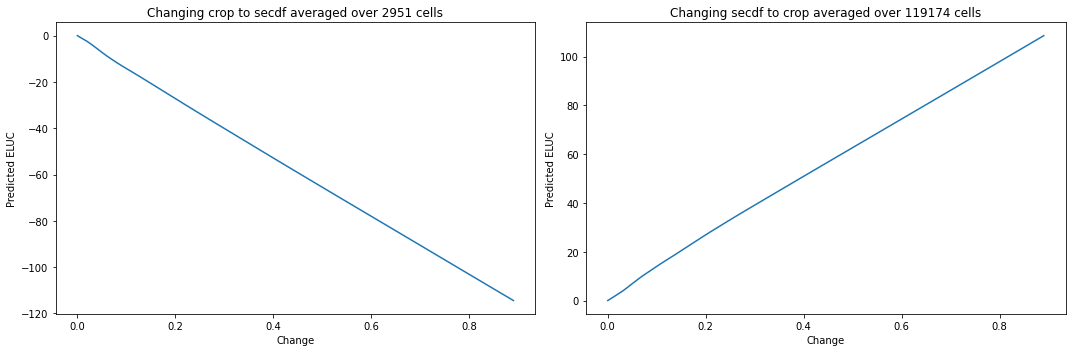

In [122]:
def check_relationship(ax, from_col, to_col):
    sample_cells = dataset.test_df[dataset.test_df[from_col] > 0.9]
    elucs = []
    for thresh in range(0, 90):
        cells = sample_cells.copy()
        for col in constants.DIFF_LAND_USE_COLS:
            cells[col] = 0

        cells[f"{from_col}_diff"] = -1 * thresh / 100
        cells[f"{to_col}_diff"] = thresh / 100

        eluc = nnp.predict(cells)["ELUC"].mean()
        elucs.append(eluc)

    ax.plot([i / 100 for i in range(90)], elucs)
    ax.set_title(f"Changing {from_col} to {to_col} averaged over {len(sample_cells)} cells")
    ax.set_ylabel("Predicted ELUC")
    ax.set_xlabel("Change")
    return ax

fig, axes = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axes[0] = check_relationship(axes[0], "crop", "secdf")
axes[1] = check_relationship(axes[1], "secdf", "crop")
plt.show()

### Train Models

#### Neural Network

In [15]:
nn_config = {
    "features": constants.NN_FEATS,
    "label": "ELUC",
    "hidden_sizes": [4096],
    "linear_skip": True,
    "dropout": 0,
    "device": "mps",
    "epochs": 3,
    "batch_size": 2048,
    "train_pct": 1,
    "step_lr_params": {"step_size": 1, "gamma": 0.1},
}
nnp = NeuralNetPredictor(nn_config)
nnp_serializer = NeuralNetSerializer()

In [5]:
# results = nnp.fit(dataset.train_df[nn_config["features"]], dataset.train_df[nn_config["label"]], verbose=True)
# nnp_serializer.save(nnp, Path("predictors/neural_network/trained_models/test"))

100%|██████████| 19028/19028 [14:19<00:00, 22.14it/s]


In [16]:
nnp = nnp_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
print(f"MAE Neural Net: {mean_absolute_error(dataset.test_df[nn_config['label']], nnp.predict(dataset.test_df[nn_config['features']]))}")

MAE Neural Net: 0.05021795257925987


#### Linear Regression

In [3]:
sklearn_serializer = SKLearnSerializer()

In [6]:
linreg_config = {
    "features": constants.DIFF_LAND_USE_COLS,
    "n_jobs": -1,
}
linreg = LinearRegressionPredictor(linreg_config)

In [ ]:
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
# sklearn_serializer.save(linreg, Path("predictors/sklearn/trained_models/no_overlap_linreg"))

In [8]:
# linreg = sklearn_serializer.load("predictors/sklearn/trained_models/no_overlap_linreg")
linreg = sklearn_serializer.load("predictors/trained_models/danyoung--eluc-global-linreg")
print(f"MAE Linear Regression: {mean_absolute_error(dataset.test_df['ELUC'], linreg.predict(dataset.test_df[constants.DIFF_LAND_USE_COLS]))}")

MAE Linear Regression: 0.07429615408182144


#### Random Forest

In [4]:
forest_config = {
    "features": constants.NN_FEATS,
    "n_jobs": -1,
    "max_features": "sqrt",
    "random_state": 42
}
forest = RandomForestPredictor(forest_config)

In [5]:
forest_year = 1982
forest.fit(dataset.train_df.loc[forest_year:][constants.NN_FEATS], dataset.train_df.loc[forest_year:]["ELUC"])
sklearn_serializer.save(forest, Path("predictors/trained_models/eds_rf"))

type: [Errno 28] No space left on device

Bad pipe message: %s [b"\xaa6\x81\x9e0\x95\xbc\x9a \xa1\x87p\xdbAf\xa3k'\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02"]
Bad pipe message: %s [b'\xdb\x05!\x8f\xa3\x82\xbc]\xefL\\S \x8b\xcd\xabF\x7f\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e

In [ ]:
# forest = sklearn_serializer.load("predictors/sklearn/trained_models/no_overlap_rf")
forest = sklearn_serializer.load(Path("predictors/trained_models/eds_rf"))
print(f"MAE Random Forest: {mean_absolute_error(dataset.test_df['ELUC'], forest.predict(dataset.test_df[constants.NN_FEATS]))}")

MAE Random Forest: 0.05921564983625365


### Create Heatmaps

In [36]:
def create_heatmap(ax: plt.Axes, model: Predictor, sample: pd.DataFrame, features=None, scale={}, title=None, cbar_ax=None, save_path=None):
    """
    Creates a 2d heatmap of the outcomes of the model on synthetic data.
    The columns correspond to current land type and the rows are the land type converted to.
    Synthetic data is created by using the non-land features of the sample and taking the cross
    join between the artificial land use change from 0 to 1 of every type.
    """
    dummy_data = []
    for i in range(len(constants.LAND_USE_COLS)):
        for j in range(len(constants.LAND_USE_COLS)):
            row = [0 for _ in range(len(constants.LAND_USE_COLS) * 2)]
            row[i] = 1.0
            if i == j:
                row[len(constants.LAND_USE_COLS) + j] = 0.0
            else:
                row[len(constants.LAND_USE_COLS) + j] = 1.0
                row[len(constants.LAND_USE_COLS) + i] = -1.0
            dummy_data.append(dict(zip(constants.LAND_USE_COLS + constants.DIFF_LAND_USE_COLS, row)))

    dummy_df = pd.DataFrame(dummy_data)

    # Gets sample of lat/lon/time/cell_area
    non_land_df = sample[constants.NONLAND_FEATURES]
    nn_input_df = dummy_df.merge(non_land_df, how="cross")
    if features:
        nn_input_df = nn_input_df[features]
    preds = model.predict(nn_input_df)
    # Aggregate samples. Since pandas merge maintains left key order, we can just sum each group of len(samples)
    # Thanks, ChatGPT!
    chunks = np.split(preds, len(preds) // len(sample))
    sums = np.sum(chunks, axis=1)
    preds = sums / len(sample)

    # Rearrange the heatmap data into 2D shape
    heatmap_data = np.zeros((len(constants.LAND_USE_COLS), len(constants.LAND_USE_COLS)))
    for i in range(len(preds)):
        heatmap_data[i // len(constants.LAND_USE_COLS), i % len(constants.LAND_USE_COLS)] = preds[i]
    
    # Hide the ability to move land to primf/primn
    idxs = [constants.LAND_USE_COLS.index(col) for col in constants.RECO_COLS]
    non_idxs = [constants.LAND_USE_COLS.index(col) for col in constants.LAND_USE_COLS if (col not in constants.RECO_COLS)]
    heatmap_data = heatmap_data[idxs + non_idxs,:]
    heatmap_data = heatmap_data[:, idxs]

    # Draw heatmap
    sorted_labels = np.array(constants.LAND_USE_COLS)[idxs + non_idxs]
    if cbar_ax:
        cbar_kwargs = {
            "cbar": True,
            "cbar_kws": {"label": "ELUC"},
            "cbar_ax": cbar_ax
        }
    else:
        cbar_kwargs = {"cbar": False}
    ax = sns.heatmap(heatmap_data,
                     center=0,
                     cmap="PiYG_r",
                     xticklabels=constants.RECO_COLS,
                     yticklabels=sorted_labels,
                     ax=ax,
                     **cbar_kwargs,
                     **scale)
    ax.invert_yaxis()
    ax.set_xlabel("To")
    ax.set_ylabel("From")
    if title:
        ax.set_title(title)
    return ax

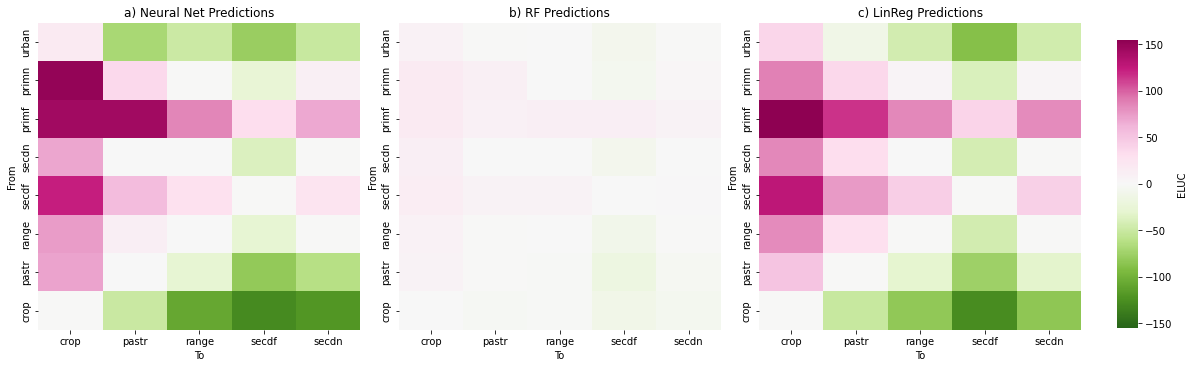

In [ ]:
sample = dataset.test_df.sample(frac=0.01, random_state=100)
fig_dir = Path("experiments/figures/eds-revisions")
scale = {"vmin": -155, "vmax": 155}
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()
cbar_ax = fig.add_axes((1.03, 0.1, 0.02, 0.8))

axes[0] = create_heatmap(axes[0], nnp, sample, save_path=fig_dir / "nn-heatmap.png", title="a) Neural Net Predictions", scale=scale, cbar_ax=cbar_ax)
axes[1] = create_heatmap(axes[1], forest, sample, save_path=fig_dir / "rf-heatmap.png", title="b) RF Predictions", scale=scale)
axes[2] = create_heatmap(axes[2], linreg, sample, save_path=fig_dir / "lr-heatmap.png", title="c) LinReg Predictions", scale=scale)

# NOTE: This doesn't save with the colorbar for some reason. I manually saved the image using jupyter notebook.
plt.savefig(fig_dir / "heatmap-fig.png", dpi=300, format="png")
plt.show()

### Statistical Significance
The models were tested by training them multiple times via [predictor_significance.py](experiments/predictor_significance.py)

#### Load Results and Perform T-Test

In [5]:
significance_path = Path("experiments/predictor_significance/no_overlap_fixed")

In [6]:
linreg_results = pd.read_csv(significance_path / "linear_regression_eval.csv")
forest_results = pd.read_csv(significance_path / "random_forest_eval.csv")
nn_results = pd.read_csv(significance_path / "neural_network_eval.csv")

In [9]:
for region in constants.COUNTRY_DICT.keys():
    lr_region_results = linreg_results[linreg_results["train"] == region][region]
    forest_region_results = forest_results[forest_results["train"] == region][region]
    nn_region_results = nn_results[nn_results["train"] == region][region]
    print(f"{region} p-value forest < nn: {ttest_ind(forest_region_results, nn_region_results, alternative='less').pvalue}")

EU p-value forest < nn: 1.0
SA p-value forest < nn: 1.601086174014152e-93
US p-value forest < nn: 1.0
ALL p-value forest < nn: 2.01460753545334e-33


#### Create Table for Latex Paper
Creates a significance table comparing the different models trained on each region and then evaluated on each region.

In [14]:
def table_results(self_name, self_results, other_results, linreg_results):
    """
    Generates results table for the overleaf paper.
    Takes in one model's results and comparison model's results as well as linreg results.
    Checks if self model is better than linreg and if self model is better than other model.
    Prints by region.
    """
    for region in constants.COUNTRY_DICT.keys():
        region_results = self_results[self_results["train"] == region]
        row = f"{self_name} ({region if region != 'ALL' else 'Global'}) & {region_results['time'].mean():.3f}"

        for eval_region in constants.COUNTRY_DICT.keys():
            # Other model significance test
            region_maes = region_results[eval_region]
            other_maes = other_results[other_results["train"] == region][eval_region]
            other_pval = ttest_ind(region_maes, other_maes, alternative="less").pvalue

            # Linreg significance test
            # We only need 1 sample from linreg because it's deterministic
            linreg_mae = linreg_results[linreg_results["train"] == region][eval_region].iloc[0]
            linreg_pval = ttest_1samp(region_maes, linreg_mae, alternative="less").pvalue

            # Best method bolding
            bold = False
            if region == eval_region and region_maes.mean() < other_maes.mean():
                bold = True

            row += f" & ${region_maes.mean():.3f}" if not bold else f" & $\\textbf{{{region_maes.mean():.3f}}}"
            if linreg_pval <= 0.01 or other_pval <= 0.01:
                row += "^{"
                if linreg_pval <= 0.01:
                    row += "*"
                if other_pval <= 0.01:
                    row += "\\dag"
                row += "}"
            row += "$"
        row += "\\\\"
        print(row)
    print("\\hline")

def generate_table(linreg_results, forest_results, nn_results):
    """
    Prints LinReg results, then generates table for RF compared to LinReg and NN, then generates table for
    NN compared to LinReg and RF.
    """
    # Linreg
    for region in constants.COUNTRY_DICT.keys():
        region_results = linreg_results[linreg_results["train"] == region]
        row = f"LinReg ({region if region != 'ALL' else 'Global'}) & {region_results.iloc[0]['time']:.3f}"
        for eval_region in constants.COUNTRY_DICT.keys():
            row += f" & {region_results[eval_region].iloc[0]:.3f}"
        row += "\\\\"
        print(row)
    print("\\hline")
    # Forest
    table_results("RF", forest_results, nn_results, linreg_results)

    # NN
    table_results("NeuralNet", nn_results, forest_results, linreg_results)

In [15]:
generate_table(linreg_results, forest_results, nn_results)

LinReg (EU) & 0.047 & 0.033 & 0.172 & 0.169 & 0.206\\
LinReg (SA) & 0.457 & 0.137 & 0.153 & 0.061 & 0.110\\
LinReg (US) & 0.331 & 0.139 & 0.146 & 0.035 & 0.073\\
LinReg (Global) & 4.644 & 0.139 & 0.150 & 0.035 & 0.074\\
\hline
RF (EU) & 17.697 & $0.064$ & $0.211^{\dag}$ & $0.161^{\dag}$ & $0.218^{\dag}$\\
RF (SA) & 209.688 & $0.133^{*\dag}$ & $\textbf{0.071}^{*\dag}$ & $0.074^{\dag}$ & $0.126^{\dag}$\\
RF (US) & 111.701 & $0.163$ & $0.185^{\dag}$ & $0.032^{*}$ & $0.094^{\dag}$\\
RF (Global) & 417.647 & $0.041^{*\dag}$ & $0.076^{*\dag}$ & $0.028^{*}$ & $\textbf{0.045}^{*\dag}$\\
\hline
NeuralNet (EU) & 10.711 & $\textbf{0.025}^{*\dag}$ & $0.277$ & $0.286$ & $0.334$\\
NeuralNet (SA) & 103.696 & $0.248$ & $0.100^{*}$ & $0.562$ & $0.399$\\
NeuralNet (US) & 73.141 & $0.136^{\dag}$ & $0.225$ & $\textbf{0.024}^{*\dag}$ & $0.150$\\
NeuralNet (Global) & 1649.193 & $0.046^{*}$ & $0.110^{*}$ & $0.025^{*\dag}$ & $0.050^{*}$\\
\hline


### Determine Significance of Lat/Lon

In [10]:
# Get random samples from the test dataset
from collections import defaultdict

def signif_latlon(ax: plt.Axes, lat_zone=(-23.4, 23.4), n=100, real_eluc=False, lat="lat", title=None, save_path=None):
    """
    Determines the significance of latitude on ELUC.
    We take a random sample of n points from the tropic of capricon and compare the ELUC of the same land change applied
    in every possible latitude.
    real_eluc: compares to the true ELUC value if True, otherwise compares to the NN predicted ELUC.
    lat: the column to use for latitude. A hack so we can also compare longitude
    Returns the dataframe sampled with the average ELUC difference when moving north/east attached.
    """
    lon = "lon" if lat == "lat" else "lat"
    test_df = dataset.test_df
    test_df = test_df[test_df["time"] == 2020]
    # lats = test_df[lat].unique()

    capricorn_df = test_df[(test_df[lat] >= lat_zone[0]) & (test_df[lat] <= lat_zone[1])]
    if n > 0:
        capricorn_df = capricorn_df.sample(n, random_state=42)

    avg_over_zero = []
    lat_dfs = []
    # Dict of lat diff -> eluc diff
    all_eluc_diffs = defaultdict(list)

    for idx, row in capricorn_df.iterrows():
        capricorn_lat = row[lat]
        
        # Compare to real ELUC or NN predicted ELUC
        if real_eluc:
            capricorn_eluc = row["ELUC"]
        else:
            capricorn_eluc = nnp.predict(pd.DataFrame([row])[constants.NN_FEATS])["ELUC"].iloc[0]

        lats = test_df[test_df[lon] == row[lon]][lat].unique()
        lat_df = pd.DataFrame([row] * len(lats)).reset_index(drop=True)
        lat_df[lat] = lats

        elucs = nnp.predict(lat_df[constants.NN_FEATS])

        eluc_diffs = np.array(elucs - capricorn_eluc)
        lat_diffs = np.array(lats - capricorn_lat)
        
        # avg_over_zero.append(np.mean(eluc_diffs[lat_diffs > 0]))

        idxs = np.argsort(lat_diffs)
        lat_diffs = lat_diffs[idxs]
        eluc_diffs = eluc_diffs[idxs]
        for lat_diff, eluc_diff in zip(lat_diffs, eluc_diffs):
            all_eluc_diffs[lat_diff].append(eluc_diff)

        ax.scatter(lat_diffs, eluc_diffs, s=1)

    lat_diffs = np.array(list(all_eluc_diffs.keys()))
    eluc_diffs = list(all_eluc_diffs.values())
    eluc_diffs = np.array([np.mean(eluc_diff) for eluc_diff in eluc_diffs])
    idxs = np.argsort(lat_diffs)
    lat_diffs = lat_diffs[idxs]
    eluc_diffs = eluc_diffs[idxs]
    ax.plot(lat_diffs, eluc_diffs, color="black", linestyle="--", linewidth=3, label="Average ELUC difference")

    ax.axhline(0, linestyle="--", color="gray")
    if title:
        ax.set_title(title)
    if lat == "lat":
        ax.set_xlabel("Latitude difference")
    elif lat == "lon":
        ax.set_xlabel("Longitude difference")
    ax.set_ylabel("ELUC difference")
    ax.legend()

    # capricorn_df["avg_eluc"] = avg_over_zero
    # capricorn_df["eluc_diffs"] = eluc_diffs_col
    return ax, lat_dfs

def plot_map(ax: plt.Axes, df: pd.DataFrame, title=None):
    min_max = max(abs(df["avg_eluc"].min()), abs(df["avg_eluc"].max()))
    norm = TwoSlopeNorm(vmin=-1 * min_max, vcenter=0, vmax=min_max)

    df["geometry"] = df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world.plot(ax=ax, color='lightgrey')

    ax.scatter(gdf.geometry.x, gdf.geometry.y, c=df["avg_eluc"], cmap="PiYG_r", norm=norm, s=5)

    ax.figure.colorbar(ScalarMappable(norm=norm, cmap="PiYG_r"), ax=ax, label="ELUC difference", shrink=0.5)
    if title:
     ax.set_title(title)
    ax.set_aspect("auto")
    return ax

from matplotlib.colors import SymLogNorm

def show_equator_points(ax: plt.Axes, lat="lat", lat_val=0.125, norm=None, title=None):
    test_df = dataset.test_df
    test_df = test_df[test_df["time"] == 2020]
    equator_df = test_df[test_df[lat] == lat_val]
    lon = "lon" if lat == "lat" else "lat"

    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world.plot(ax=ax, color='lightgrey')

    minmax = 0
    lat_dfs = []
    for idx, row in equator_df.iterrows():
        equator_eluc = nnp.predict(pd.DataFrame([row])[constants.NN_FEATS])["ELUC"].iloc[0]

        lats = test_df[test_df[lon] == row[lon]][lat].unique()
        lat_df = pd.DataFrame([row] * len(lats)).reset_index(drop=True)
        lat_df[lat] = lats

        elucs = nnp.predict(lat_df[constants.NN_FEATS])

        eluc_diffs = np.array(elucs - equator_eluc)
        lat_df["eluc_diff"] = eluc_diffs
        lat_df["geometry"] = lat_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

        minmax = max(minmax, abs(lat_df["eluc_diff"].min()), abs(lat_df["eluc_diff"].max()))
        lat_dfs.append(lat_df)

    if not norm:
        # norm = SymLogNorm(linthresh=0.1, linscale=1.0, vmin=-1 * minmax, vmax=minmax, base=2)
        norm = TwoSlopeNorm(vmin=-1 * minmax, vcenter=0, vmax=minmax)

    for lat_df in lat_dfs:
        gdf = gpd.GeoDataFrame(lat_df, geometry="geometry")
        gdf.set_crs(epsg=4326, inplace=True)
        ax.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf["eluc_diff"], cmap="PiYG_r", norm=norm, s=5)

    if lat == "lat":
        ax.axhline(lat_val, linestyle="--", color="black")
    else:
        ax.axvline(lat_val, linestyle="--", color="black")

    if title:
        ax.set_title(title)
    ax.set_aspect("auto")
    return ax, norm

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_73493/3159308089.py:103: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_73493/3159308089.py:103: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


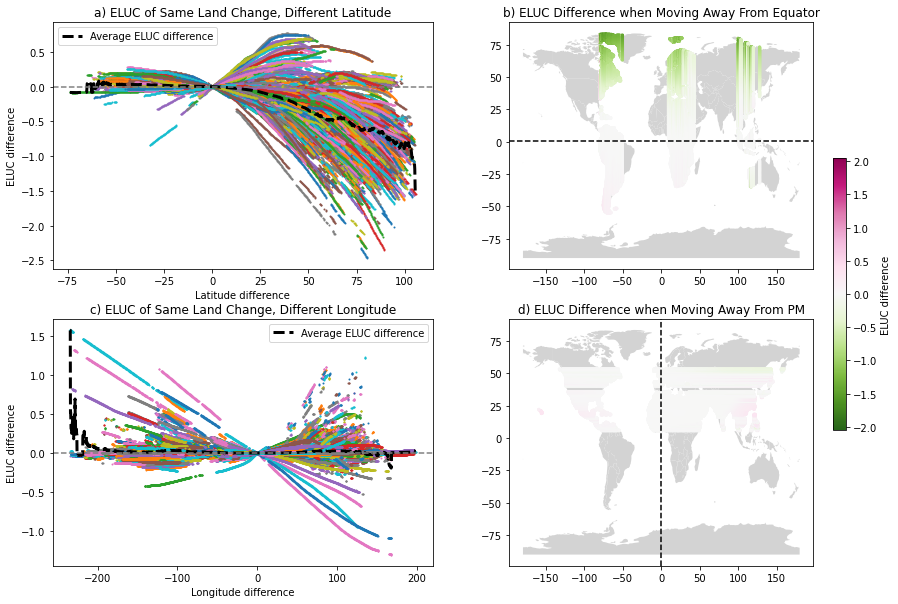

In [11]:
fig_dir = Path("experiments/figures/eds")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
all_lat_zone = (-1000, 1000)
axes[0], base_df = signif_latlon(axes[0], n=1000, title="a) ELUC of Same Land Change, Different Latitude")
africa_lons = (-20, 55)
axes[2], lon_df = signif_latlon(axes[2], n=1000, lat="lon", lat_zone=africa_lons, title="c) ELUC of Same Land Change, Different Longitude")
axes[1], norm = show_equator_points(axes[1], lat="lat", lat_val=0.125, title="b) ELUC Difference when Moving Away From Equator")
fig.colorbar(ScalarMappable(norm=norm, cmap="PiYG_r"), ax=[axes[1], axes[3]], label="ELUC difference", shrink=0.5)
axes[3], _ = show_equator_points(axes[3], lat="lon", lat_val=0.125, norm=norm, title="d) ELUC Difference when Moving Away From PM")
# plt.savefig(fig_dir / "latlon-fig.png", format="png", dpi=300)
plt.show()

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_73493/3554908464.py:28: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


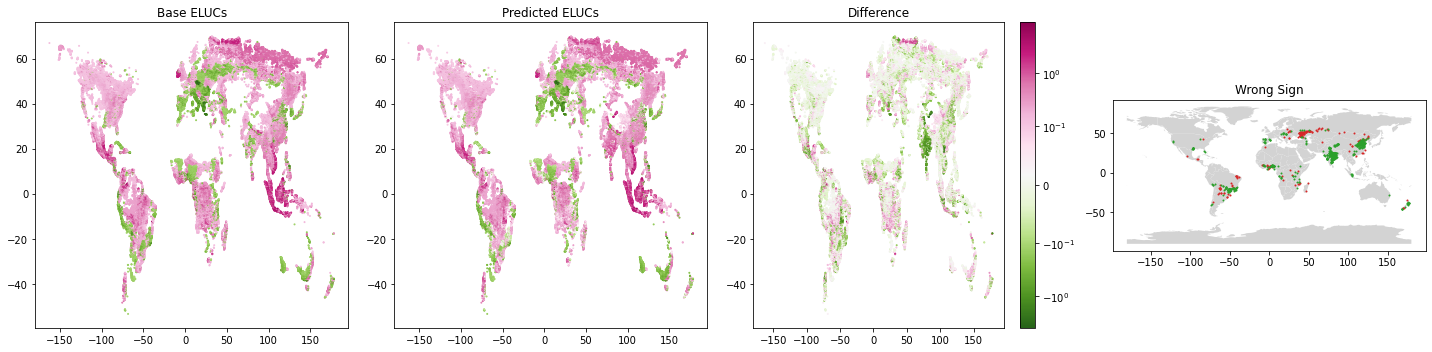

In [57]:
def compare_changes():
    test_df = dataset.test_df.copy()
    test_df = test_df[test_df["time"] == 2020]
    test_df = test_df[abs(test_df["ELUC"]) > 0.1]

    elucs = nnp.predict(test_df[constants.NN_FEATS])

    test_df["geometry"] = test_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(test_df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)
    centered = SymLogNorm(vmin=elucs["ELUC"].min(), vmax=elucs["ELUC"].max(), linthresh=0.1, linscale=1.0)
    scatter = axes[0].scatter(gdf.geometry.x, gdf.geometry.y, c=gdf["ELUC"], cmap="PiYG_r", norm=centered, s=1)
    axes[0].set_title("Base ELUCs")
    axes[1].scatter(gdf.geometry.x, gdf.geometry.y, c=elucs["ELUC"], cmap="PiYG_r", s=1, norm=centered)
    axes[1].set_title("Predicted ELUCs")
    axes[2].scatter(gdf.geometry.x, gdf.geometry.y, c=gdf["ELUC"] - elucs["ELUC"], cmap="PiYG_r", norm=centered, s=1)
    axes[2].set_title("Difference")

    pos_sign = test_df[((test_df["ELUC"] > 0) & (elucs["ELUC"] < 0))]
    neg_sign = test_df[((test_df["ELUC"] < 0) & (elucs["ELUC"] > 0))]
    pgdf = gpd.GeoDataFrame(pos_sign, geometry="geometry")
    pgdf.set_crs(epsg=4326, inplace=True)
    ngdf = gpd.GeoDataFrame(neg_sign, geometry="geometry")
    ngdf.set_crs(epsg=4326, inplace=True)

    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world.plot(ax=axes[3], color='lightgrey')

    axes[3].scatter(pgdf.geometry.x, pgdf.geometry.y, c="C3", s=1)
    axes[3].scatter(ngdf.geometry.x, ngdf.geometry.y, c="C2", s=1)
    axes[3].set_title("Wrong Sign")
    
    fig.colorbar(scatter, ax=axes[2])
    plt.show()

compare_changes()

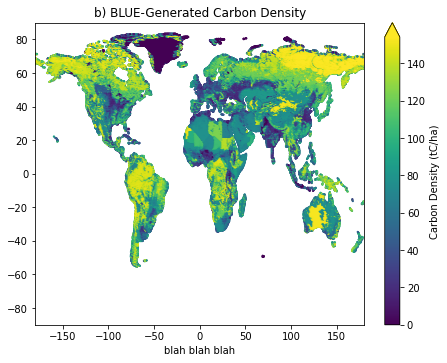

In [236]:
def convert_all(ax: plt.Axes):
    test_df = dataset.test_df.copy()
    test_df = test_df[test_df["time"] == 2020]

    for col in constants.DIFF_LAND_USE_COLS:
        test_df[col] = 0

    land = [c for c in constants.LAND_USE_COLS if c not in ["primn", "secdf", "secdn"]]
    for col in land:
        test_df[f"{col}_diff"] = -1 * test_df[col]
    
    test_df["primf_diff"] = test_df[land].sum(axis=1) - test_df["primf"]

    elucs = nnp.predict(test_df[constants.NN_FEATS])

    test_df["geometry"] = test_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(test_df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)

    scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y, c=elucs["ELUC"], cmap="viridis_r", s=1)
    ax.set_title("Predicted ELUC when converting all to primf")
    fig.colorbar(scatter, ax=ax, label="Predicted ELUC")
    return ax

def deforest(ax: plt.Axes):
    test_df = dataset.test_df.copy()
    # test_df = test_df[(test_df["lat"] >= -37) & (test_df["lat"] < 37) & (test_df["lon"] > -25) & (test_df["lon"] < 50)]
    # test_df = test_df[(test_df["lat"] > 20) & (test_df["lat"] < 30) & (test_df["lon"] > 15) & (test_df["lon"] < 20)]
    test_df = test_df[test_df["time"] == 2020]

    for c in constants.DIFF_LAND_USE_COLS:
        test_df[c] = 0

    land = [c for c in constants.LAND_USE_COLS]
    for c in land:
        test_df[f"{c}_diff"] = -1 * test_df[c]

    test_df["crop_diff"] = test_df[land].sum(axis=1) - test_df["crop"]

    test_df["geometry"] = test_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(test_df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)

    elucs = nnp.predict(test_df[constants.NN_FEATS])

    scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y, c=elucs["ELUC"], cmap="viridis", s=1)
    ax.set_ylim(-90, 90)
    ax.set_xlim(-180, 180)
    title = "b) BLUE-Generated Carbon Density"
    ax.set_title(title)
    ax.set_xlabel("blah blah blah")
    fig.colorbar(scatter, ax=ax, label="Carbon Density (tC/ha)", extend="max")
    return ax

fig, axes = plt.subplots(figsize=(6.4, 5.15), tight_layout=False)
# fig, axes = plt.subplots(1, 1, figsize=(15, 5), tight_layout=True)
axes = deforest(axes)
# axes[1] = deforest(axes[1], random=True)
# convert_all(axes)
# axes = deforest(axes)
plt.savefig(fig_dir / "template-stuff.png", format="png", dpi=300)
plt.show()
        

0.050217953


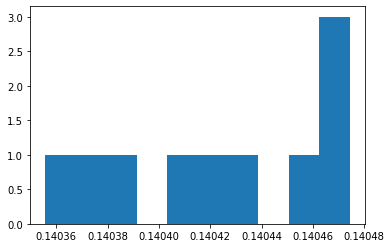

In [212]:
def check_coord_importance():
    test_df = dataset.test_df.copy()
    true_elucs = test_df["ELUC"]
    base_pred = nnp.predict(test_df[constants.NN_FEATS])["ELUC"]
    base_mae = mean_absolute_error(true_elucs, base_pred)
    print(base_mae)

    maes = []
    for _ in range(10):
        compare_df = test_df.copy()
        compare_df["lat"] = compare_df["lat"].sample(frac=1).values
        compare_df["lon"] = compare_df["lon"].sample(frac=1).values
        compare_elucs = nnp.predict(compare_df[constants.NN_FEATS])
        mae = mean_absolute_error(base_pred, compare_elucs["ELUC"])
        maes.append(mae)

    plt.hist(maes)
    plt.show()
    
check_coord_importance()


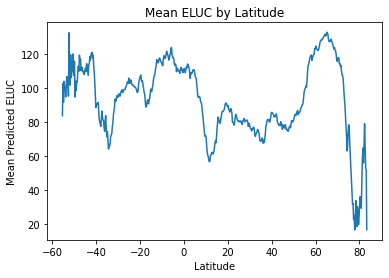

In [ ]:
def plot_mean(ax: plt.Axes):
    test_df = dataset.test_df.copy()
    # test_df = test_df[(test_df["lat"] >= -37) & (test_df["lat"] < 37) & (test_df["lon"] > -25) & (test_df["lon"] < 50)]
    # test_df = test_df[(test_df["lat"] > 20) & (test_df["lat"] < 30) & (test_df["lon"] > 15) & (test_df["lon"] < 20)]
    test_df = test_df[test_df["time"] == 2020]

    for c in constants.DIFF_LAND_USE_COLS:
        test_df[c] = 0

    land = [c for c in constants.LAND_USE_COLS]
    for c in land:
        test_df[f"{c}_diff"] = -1 * test_df[c]

    test_df["crop_diff"] = test_df[land].sum(axis=1) - test_df["crop"]

    elucs = nnp.predict(test_df[constants.NN_FEATS])

    test_df["ELUC"] = elucs["ELUC"]
    agg = test_df.groupby("lat").agg({"ELUC": "mean"})
    ax.plot(agg.index, agg["ELUC"])
    ax.set_title("Mean ELUC by Latitude")
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Mean Predicted ELUC")
    return ax

fig, ax = plt.subplots()
plot_mean(ax)
plt.show()

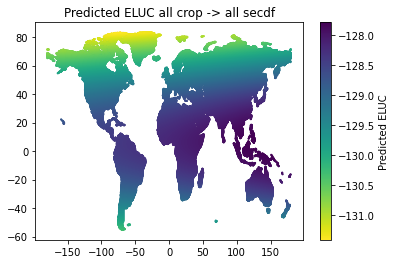

In [70]:
def convert_fantasy(col):
    test_df = dataset.test_df.copy()
    test_df = test_df[test_df["time"] == 2020]

    for c in constants.LAND_USE_COLS:
        test_df[f"{c}_diff"] = 0
        test_df[c] = 0

    test_df[col] = 1
    test_df[f"{col}_diff"] = -1
    test_df["secdf_diff"] = 1

    elucs = nnp.predict(test_df[constants.NN_FEATS])

    test_df["geometry"] = test_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    gdf = gpd.GeoDataFrame(test_df, geometry="geometry")
    gdf.set_crs(epsg=4326, inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y, c=elucs["ELUC"], cmap="viridis_r", s=1)
    ax.set_title("Predicted ELUC all crop -> all secdf")
    fig.colorbar(scatter, ax=ax, label="Predicted ELUC")
    plt.show()

convert_fantasy("crop")